In [3]:
import json
from model import *
from custom_recurrents import AttentionDecoder
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"]=10,10
from utils import *
from predict import *
from keras.models import load_model
from custom_recurrents import AttentionDecoder

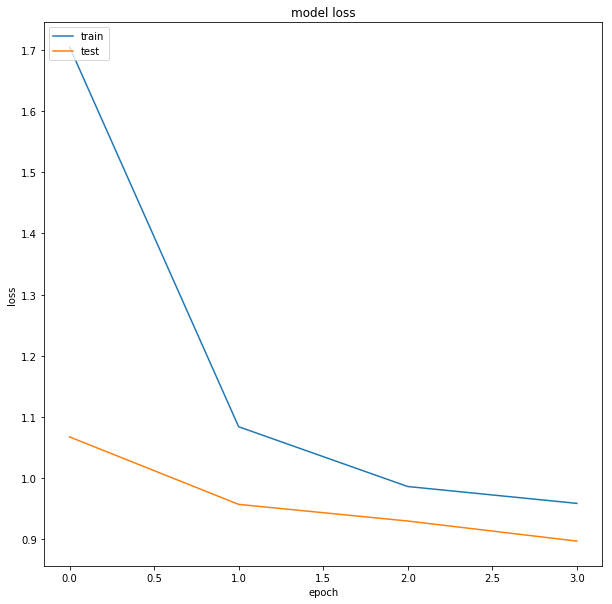

In [6]:
# summarize history for loss
plot_loss('/home/CONCURASP/kumara/udacity_ocr_refactor/model/sample/history.json')

In [ ]:
# from keras.models import load_model
# from predict import get_features,get_text
# from custom_recurrents import AttentionDecodert
# model = load_model('/home/CONCURASP/kumara/udacity_ocr_refactor/model/sample/ocr_extraction_model.h5',custom_objects={'AttentionDecoder':AttentionDecoder})
# base_path='/home/CONCURASP/kumara/udacity_ocr_refactor/data/ramdisk/max/90kDICT32px/'
# path = '1/1/100_Classmates_13991.jpg' 
# final_path = base_path+path
# features = get_features(final_path)
# pred = model.predict(features)


In [2]:
from predict import *
base_path='/home/CONCURASP/kumara/udacity_ocr_refactor/data/ramdisk/max/90kDICT32px/'
path = '1/1/100_Classmates_13991.jpg' 
final_path = base_path+path
vocab_file = '/home/CONCURASP/kumara/udacity_ocr_refactor/src/rcptAlphabet.json'
model_file = '/home/CONCURASP/kumara/udacity_ocr_refactor/model/iteration_1/ocr_extraction_model.h5'
#img = '/home/CONCURASP/kumara/udacity_ocr_refactor/src/5AA93EB6ABB138AE87010F44D68561DF.jpg'
call_predict(vocab_file,model_file,final_path)

inputs shape: (?, 40, 512)
Classmates


'Classmates'

In [16]:
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from PIL import Image
from cv2 import boundingRect, countNonZero, cvtColor, drawContours, findContours, getStructuringElement, imread, \
    morphologyEx, pyrDown, rectangle, threshold
def get_text_boxes(large):
    """
    Utility function to get image text boxes
    -----
    - img: np-array image of shape (H, W, C)
    Returns
    -------
    - output: {(x,y,rect_height, rect_width): numpy_array image boxes}
    """

    # Downsample (in half) if the image is large
    
    if float(large.size / 3) > 1000 * 1000:
        shrink = True
    else:
        shrink = False
    print("shrink", shrink)
    if shrink:
        rgb = pyrDown(large)
    else:
        rgb = large

    scale_width = 100
    scale_height = 500
    # Apply grayscale to the rgb image
    small = cvtColor(rgb, cv2.COLOR_BGR2GRAY)

    
    if rgb.shape[1] > rgb.shape[0]:
        im_height = rgb.shape[1]
        im_width = rgb.shape[0]
    else:
        im_height = rgb.shape[0]
        im_width = rgb.shape[1]
    

        
    box_width = int(im_width / scale_width)
    box_height = int(im_height / scale_height)


    
    morph_kernel = getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    grad = morphologyEx(small, cv2.MORPH_GRADIENT, morph_kernel)
    _, bw = threshold(src=grad, thresh=10, maxval=100, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    morph_kernel = getStructuringElement(cv2.MORPH_RECT, (box_width, box_height))
    connected = morphologyEx(bw, cv2.MORPH_CLOSE, morph_kernel)
    
    mask = np.zeros(bw.shape, np.uint8)
    print(mask.shape)
    
    contours, hierarchy = findContours(connected, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    boxes_keys = {}
    
    for idx in range(0, len(hierarchy[0])):
        rect = x, y, rect_width, rect_height = boundingRect(contours[idx])
        y_ = int(y / 10) * 10
        # Fill the contour
        mask = drawContours(mask, contours, idx, (255, 255, 2555), cv2.FILLED)
        # Ratio of non-zero pixels in the filled region
        r = float(countNonZero(mask)) / (rect_width * rect_height)
        if r > 0.45 \
            and rect_height > box_width + 5 \
            and rect_width > box_width + 5 \
            and rect_width < int(rgb.shape[1] / 2) \
            and rect_height < int(rgb.shape[0] / 5):
            try:
                img = Image.fromarray(rgb[y - 2:y + rect_height + 2, x - 2:x + rect_width + 2], 'RGB')
            except ValueError:
                img = Image.fromarray(rgb[y:y + rect_height, x:x + rect_width], 'RGB')
            boxes_keys[(y_, x, rect_height, rect_width)] = img
    num_boxes = len(boxes_keys)
    box_lookup = dict(zip(range(0, num_boxes), sorted(list(boxes_keys.keys()))))
    X_train = np.zeros((num_boxes, max_slicenum, slice_height, slice_width, 1))
    model = load_model('/home/CONCURASP/kumara/udacity_ocr_refactor/model/ocr_extraction_model.h5',custom_objects={'AttentionDecoder':AttentionDecoder})
    for l in range(0, num_boxes):
        output = np.zeros((max_slicenum, slice_height, slice_width, 1))
        img_np = boxes_keys.get(box_lookup.get(l))
        img_np_grey = pre_process_real(img_np)
        num_slices_ = int(img_np_grey.shape[1] / slice_width)
        for k in range(1, num_slices_ + 1):
            output[k - 1, :, :, 0] = img_np_grey[:, (k - 1) * slice_width:k * slice_width]
            X_train[l, :, :, :, :] = output
        pred = model.predict(X_train)
        pred_string = pred_string[:pred_string.find(get_end_char(pred_string))]
        
        print(pred)
        print(pred_string)

In [ ]:
from io import BytesIO
def pre_process_real(img_):
        """
        Utility function to re-shape and pre-process text 
        boxes that can be fed into CRNN model
        Input
        -----
        - img: np-array image of shape (H, W, C)
        Returns
        -------
        - output: np-array image of shape (H, W)
        """

        # Convert to the same height and adjust width accordingly
        a, b = img_.size
        scale_factor = int(a / float(b))
        if scale_factor < 1:
            scale_factor = 1
        total_width = scale_factor * 40
        if total_width > 480:
            total_width = 480
        new_im = img_.resize((total_width, slice_height), Image.ANTIALIAS)

        # Convert it back to numpy array
        img_np = np.asarray(new_im)

        # Greyscale the image
        img_np_grey = rgb2gray(img_np)

        return img_np_grey

def predict(img):
        """
        Model prediction function to get ocr from an image
        -----
        - img: bytes of input file
        Returns
        -------
        - output: dictionary
        """

        # Read the image
        img = Image.open(BytesIO(img))
        try:
            img = np.array(img)[:, :, 0:3]
        except IndexError:
            return [{'value': 'Image quality is too low, please submit at least 500 by 500 rgb ones ', 'score': 0.0}]
        if float(img.size / 3) < 500 * 500:
            return [{'value': 'Image quality is too low, please submit at least 500 by 500 rgb ones ', 'score': 0.0}]

        # Get image text boxes from left to right, top to bottom
        # boxes_keys: {(x,y,rect_height, rect_width): numpy_array image boxes}
        boxes_keys = get_text_boxes(img)


img = '/home/CONCURASP/kumara/udacity_ocr_refactor/src/5AA93EB6ABB138AE87010F44D68561DF.jpg'
with open(img, "rb") as imageFile:
    f = imageFile.read()
    #b = bytearray(f)
predict(f)

shrink False
(1111, 666)
{(750, 181, 28, 78): <PIL.Image.Image image mode=RGB size=82x32 at 0x7F82DEF4DF98>, (750, 83, 23, 76): <PIL.Image.Image image mode=RGB size=80x27 at 0x7F82DEF4DDA0>, (740, 282, 22, 17): <PIL.Image.Image image mode=RGB size=21x26 at 0x7F82DEF4DE80>, (740, 322, 23, 115): <PIL.Image.Image image mode=RGB size=119x27 at 0x7F82DEF82240>, (710, 164, 23, 99): <PIL.Image.Image image mode=RGB size=103x27 at 0x7F82DEF822B0>, (710, 65, 23, 77): <PIL.Image.Image image mode=RGB size=81x27 at 0x7F82DEF82320>, (710, 575, 22, 17): <PIL.Image.Image image mode=RGB size=21x26 at 0x7F82DEF82390>, (710, 612, 23, 37): <PIL.Image.Image image mode=RGB size=41x27 at 0x7F82DEF82400>, (640, 362, 23, 17): <PIL.Image.Image image mode=RGB size=21x27 at 0x7F82DEF82470>, (640, 381, 24, 76): <PIL.Image.Image image mode=RGB size=80x28 at 0x7F82DEF824E0>, (640, 574, 23, 18): <PIL.Image.Image image mode=RGB size=22x27 at 0x7F82DEF82550>, (630, 612, 24, 37): <PIL.Image.Image image mode=RGB size=41x

In [4]:
from keras.models import load_model
model_file = '/home/CONCURASP/kumara/udacity_ocr_refactor/model/iteration_1/ocr_extraction_model.h5'
model = load_model(model_file,custom_objects={'AttentionDecoder': AttentionDecoder})
model.summary()

inputs shape: (?, 40, 512)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 40, 20, 1)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 40, 20, 64)    640       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 20, 10, 64)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 20, 10, 128)   73856     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 24, 10, 5, 128)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 24, 10, 5, 256)    295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 10, 5, 25